In [56]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

df = pl.read_csv("./DSU-Dataset.csv")
col = df["Date"].str.to_date()
df = df.with_columns(col)

df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,date,f64,str,i64,i64
"""A""",2018-01-01,0.0,"""BREATHING PROBLEM""",1,1
"""A""",2018-01-01,0.0,"""BURN""",1,0
"""A""",2018-01-01,0.0,"""SHAKING""",1,1
"""A""",2018-01-01,0.0,"""VOMITING""",1,0
"""A""",2018-01-01,1.0,"""FROSTBITE""",1,0


In [ ]:
block_ranges = { 1: range(0, 6),
                 2: range(6, 12),
                 3: range(12, 18),
                 4: range(18, 24) }

min_date = df["Date"].min()
max_date = df["Date"].max()
begin_covid_date = df.filter(pl.col("Date").dt.year() == 2020).select(pl.col("Date")).min()
end_covid_date = df.filter(pl.col("Date").dt.year() == 2021).select(pl.col("Date")).max()


hourly_blocks_df = df.with_columns(
    pl.col("Hour").map_elements(lambda hr: next(block for block, hrs in block_ranges.items() if hr in hrs)).alias("Hour")
)
hourly_blocks_df = hourly_blocks_df.group_by(["Site", "Date", "Hour"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
hourly_blocks_df = hourly_blocks_df.sort(["Site", "Date", "Hour"])
hourly_blocks_df = hourly_blocks_df.with_columns(
    [
        pl.col("Date").dt.year().alias("Year"),
        pl.col("Date").dt.month().alias("Month"),
        pl.col("Date").dt.day().alias("Day"),
        pl.col("Date").dt.weekday().alias("Weekday"),
    ]
).drop("Date").select(["Site", "Year", "Month", "Day", "Weekday", "Hour", "ED Enc", "ED Enc Admitted"])

# remove covid data
hourly_blocks_df = hourly_blocks_df.filter(pl.col("Year") != 2020).filter(pl.col("Year") != 2021)

hourly_blocks_df.head()

Site,Year,Month,Day,Weekday,Hour,ED Enc,ED Enc Admitted
str,i32,i8,i8,i8,i64,i64,i64
"""A""",2018,1,1,1,1,16,6
"""A""",2018,1,1,1,2,25,8
"""A""",2018,1,1,1,3,52,16
"""A""",2018,1,1,1,4,36,10
"""A""",2018,1,2,2,1,18,5


# Site A Random Forest Model

In [58]:
siteA_train = hourly_blocks_df.filter(pl.col("Site") == "A")
siteA_X = siteA_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteA_Y = siteA_train.select(["ED Enc", "ED Enc Admitted"])
siteA_X_train, siteA_X_test, siteA_Y_train, siteA_Y_test = train_test_split(siteA_X, siteA_Y, test_size=0.2, random_state=42)
siteA_model = RandomForestRegressor().fit(siteA_X_train, siteA_Y_train)

In [59]:
print(f"R² score of {siteA_model.score(siteA_X_test, siteA_Y_test)}")

R² score of 0.6325671326154805


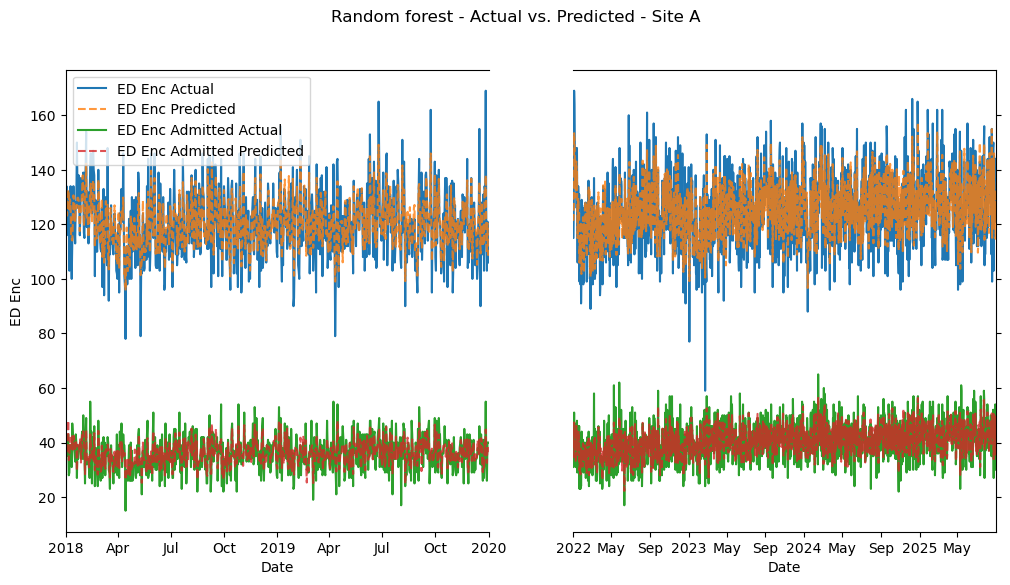

In [85]:
plot_df = siteA_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_model.predict(siteA_X)
predict_df = siteA_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("Random forest - Actual vs. Predicted - Site A")
plt.show()

# Site B Random Forest Model

In [60]:
siteB_train = hourly_blocks_df.filter(pl.col("Site") == "B")
siteB_X = siteB_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteB_Y = siteB_train.select(["ED Enc", "ED Enc Admitted"])
siteB_X_train, siteB_X_test, siteB_Y_train, siteB_Y_test = train_test_split(siteB_X, siteB_Y, test_size=0.2, random_state=42)
siteB_model = RandomForestRegressor().fit(siteB_X_train, siteB_Y_train)

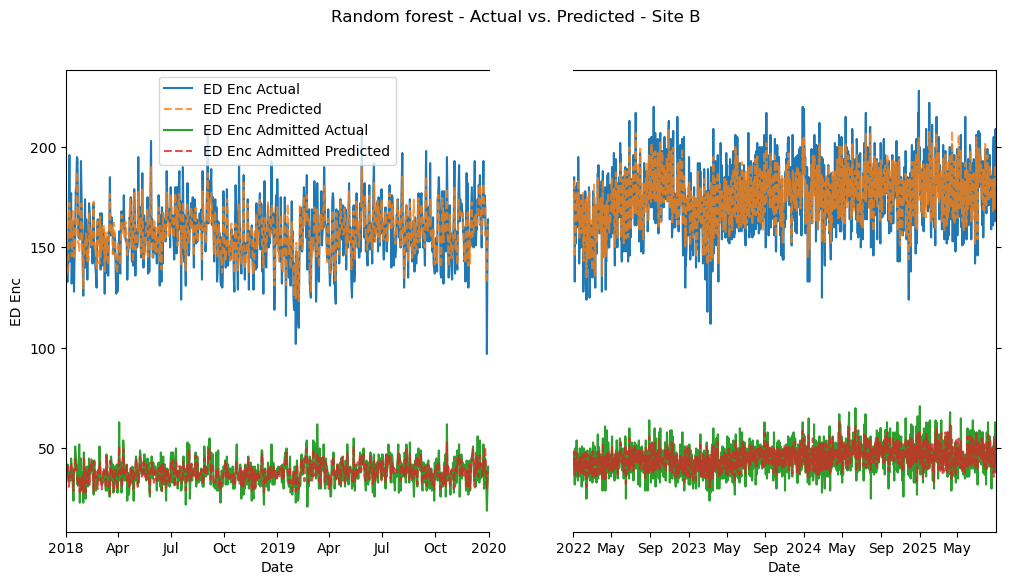

In [87]:
plot_df = siteB_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_model.predict(siteB_X)
predict_df = siteB_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("Random forest - Actual vs. Predicted - Site B")
plt.show()

In [61]:
print(f"R² score of {siteB_model.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.6473431136113513


# Site C Random Forest Model

In [62]:
siteC_train = hourly_blocks_df.filter(pl.col("Site") == "C")
siteC_X = siteC_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteC_Y = siteC_train.select(["ED Enc", "ED Enc Admitted"])
siteC_X_train, siteC_X_test, siteC_Y_train, siteC_Y_test = train_test_split(siteC_X, siteC_Y, test_size=0.2, random_state=42)
siteC_model = RandomForestRegressor().fit(siteC_X_train, siteC_Y_train)

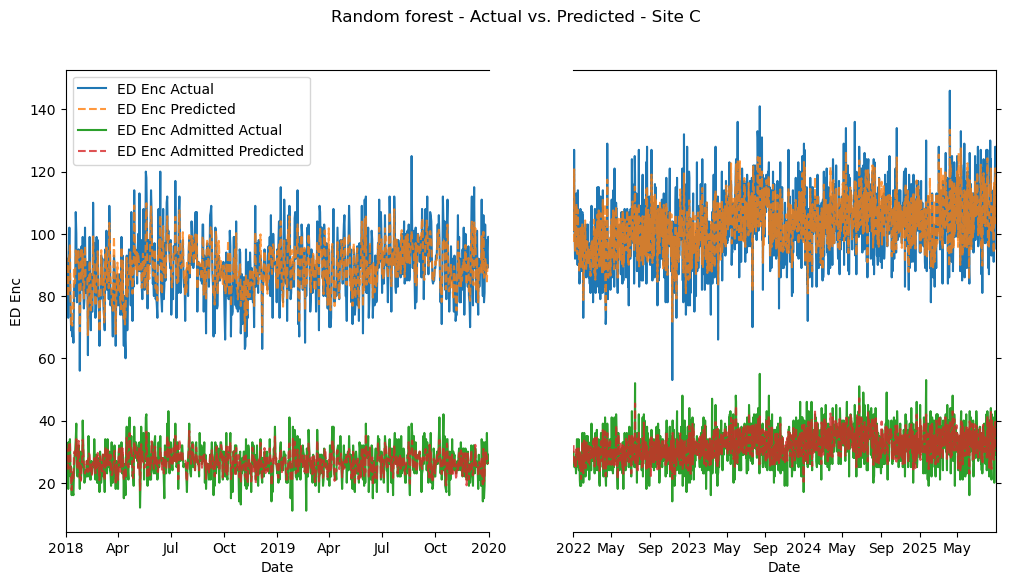

In [88]:
plot_df = siteC_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_model.predict(siteC_X)
predict_df = siteC_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("Random forest - Actual vs. Predicted - Site C")
plt.show()

In [63]:
print(f"R² score of {siteC_model.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.6127812538418639


# Site D Random Forest Model

In [64]:
siteD_train = hourly_blocks_df.filter(pl.col("Site") == "D")
siteD_X = siteD_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteD_Y = siteD_train.select(["ED Enc", "ED Enc Admitted"])
siteD_X_train, siteD_X_test, siteD_Y_train, siteD_Y_test = train_test_split(siteD_X, siteD_Y, test_size=0.2, random_state=42)
siteD_model = RandomForestRegressor().fit(siteD_X_train, siteD_Y_train)

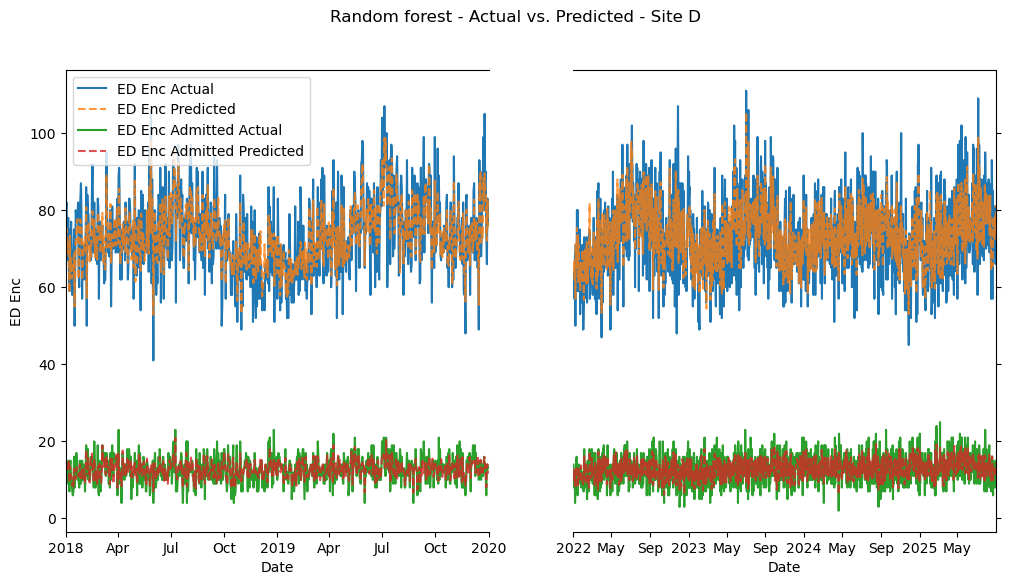

In [89]:
plot_df = siteD_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_model.predict(siteD_X)
predict_df = siteD_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("Random forest - Actual vs. Predicted - Site D")
plt.show()

In [65]:
print(f"R² score of {siteD_model.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.47301679956526516


# Linear regression?
We can see from the EDA that, if we take out the COVID data, the data fits pretty closely to a line for each site.

## Site A 

In [66]:
from sklearn.linear_model import LinearRegression, Ridge

siteA_linreg = Ridge(alpha=1).fit(siteA_X_train, siteA_Y_train)
score = siteA_linreg.score(siteA_X_test, siteA_Y_test)
print(f"Ridge Regression R² score of {score}")

Ridge Regression R² score of 0.44831178406277344


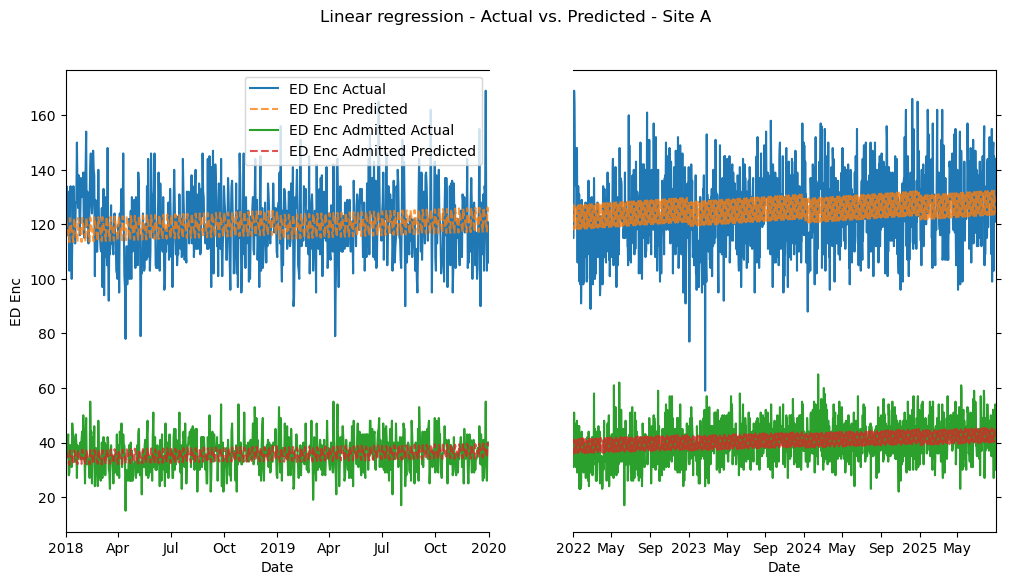

In [ ]:
plot_df = siteA_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_linreg.predict(siteA_X)
predict_df = siteA_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("Linear regression - Actual vs. Predicted - Site A")
plt.show()

## Site B

In [68]:
siteB_linreg = LinearRegression().fit(siteB_X_train, siteB_Y_train)
print(f"R² score of {siteB_linreg.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.5246432827003147


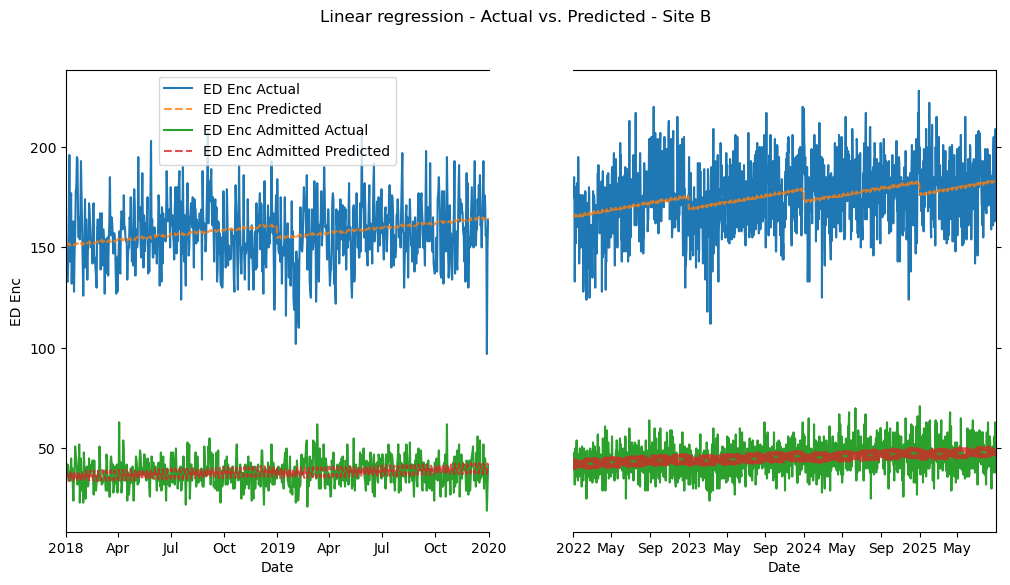

In [82]:
plot_df = siteB_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_linreg.predict(siteB_X)
predict_df = siteB_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

fig.suptitle("Linear regression - Actual vs. Predicted - Site B")
plt.show()

## Site C

In [69]:
siteC_linreg = LinearRegression().fit(siteC_X_train, siteC_Y_train)
print(f"R² score of {siteC_linreg.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.41803995754888


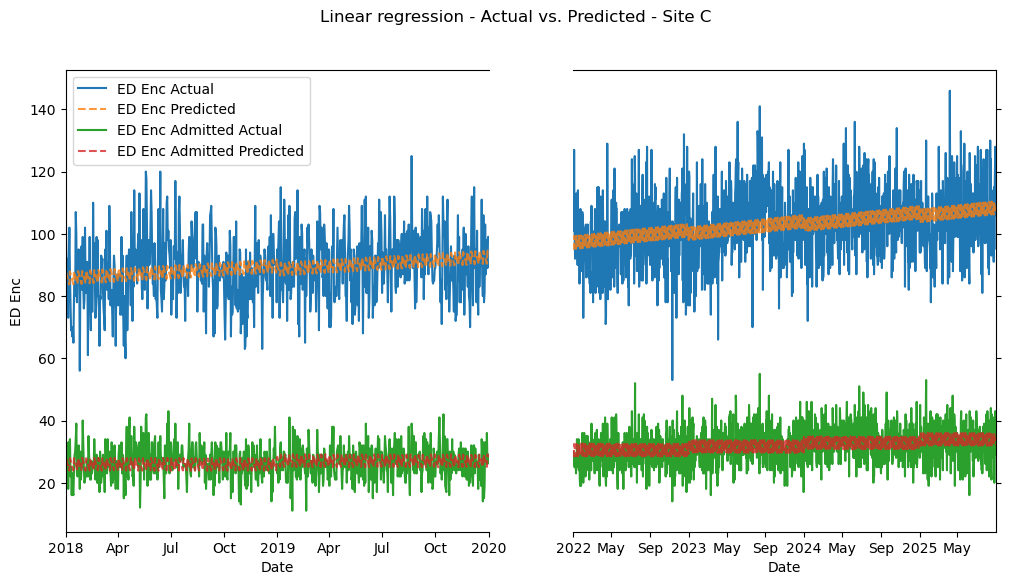

In [83]:
plot_df = siteC_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_linreg.predict(siteC_X)
predict_df = siteC_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("Linear regression - Actual vs. Predicted - Site C")
plt.show()

## Site D

In [70]:
siteD_linreg = LinearRegression().fit(siteD_X_train, siteD_Y_train)
print(f"R² score of {siteD_linreg.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.2842632788124213


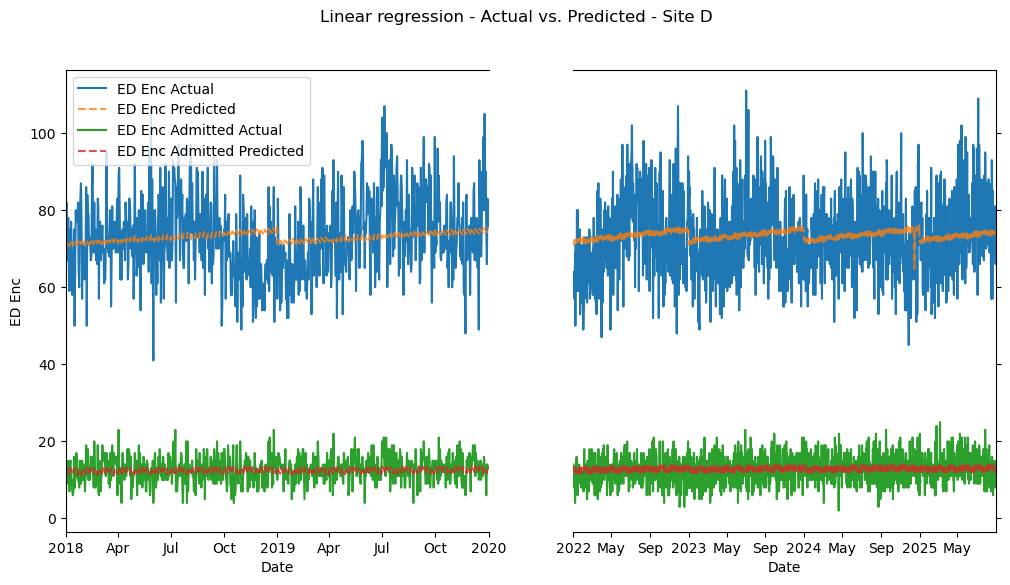

In [84]:
plot_df = siteD_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_linreg.predict(siteD_X)
predict_df = siteD_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("Linear regression - Actual vs. Predicted - Site D")
plt.show()

# CATboost?
Gradient boosted trees

In [71]:
from catboost import CatBoostRegressor, Pool
siteA_train_pool = Pool(siteA_X_train.to_pandas(), siteA_Y_train.to_pandas(), cat_features=siteA_X.columns)
siteA_test_pool = Pool(siteA_X_test.to_pandas(), siteA_Y_test.to_pandas(), cat_features=siteA_X.columns)

siteA_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteA_catmodel.fit(siteA_train_pool)

print(f"R² score of {siteA_catmodel.score(siteA_test_pool)}")

0:	learn: 12.3217568	total: 74.4ms	remaining: 1m 14s
1:	learn: 11.5069669	total: 125ms	remaining: 1m 2s
2:	learn: 10.8028442	total: 183ms	remaining: 1m
3:	learn: 10.1875970	total: 244ms	remaining: 1m
4:	learn: 9.6871008	total: 304ms	remaining: 1m
5:	learn: 9.2332199	total: 367ms	remaining: 1m
6:	learn: 8.8530527	total: 406ms	remaining: 57.6s
7:	learn: 8.5200892	total: 465ms	remaining: 57.7s
8:	learn: 8.2409481	total: 522ms	remaining: 57.5s
9:	learn: 8.0111158	total: 586ms	remaining: 58s
10:	learn: 7.8321473	total: 625ms	remaining: 56.2s
11:	learn: 7.6738652	total: 717ms	remaining: 59.1s
12:	learn: 7.5337393	total: 772ms	remaining: 58.6s
13:	learn: 7.4100242	total: 833ms	remaining: 58.6s
14:	learn: 7.3041924	total: 892ms	remaining: 58.6s
15:	learn: 7.2310551	total: 929ms	remaining: 57.1s
16:	learn: 7.1737082	total: 957ms	remaining: 55.4s
17:	learn: 7.1070677	total: 1.01s	remaining: 55.3s
18:	learn: 7.0674360	total: 1.05s	remaining: 54.4s
19:	learn: 7.0169831	total: 1.12s	remaining: 54.9

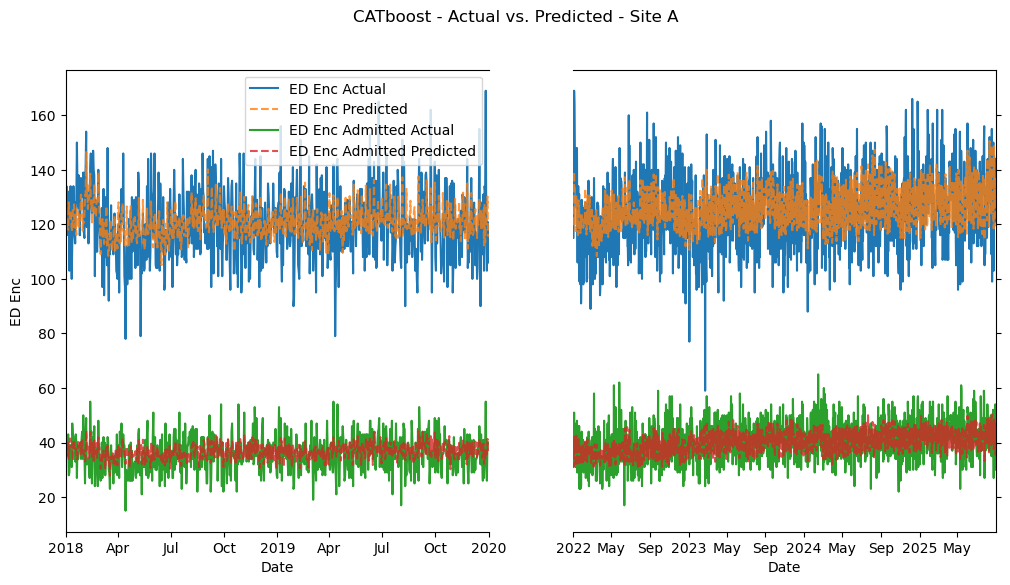

In [92]:
plot_df = siteA_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_catmodel.predict(siteA_X.to_pandas())
predict_df = siteA_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("CATboost - Actual vs. Predicted - Site A")
plt.show()

In [93]:
siteB_train_pool = Pool(siteB_X_train.to_pandas(), siteB_Y_train.to_pandas(), cat_features=siteB_X.columns)
siteB_test_pool = Pool(siteB_X_test.to_pandas(), siteB_Y_test.to_pandas(), cat_features=siteB_X.columns)

siteB_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteB_catmodel.fit(siteB_train_pool)

print(f"R² score of {siteB_catmodel.score(siteB_test_pool)}")

0:	learn: 15.4809831	total: 69.5ms	remaining: 1m 9s
1:	learn: 14.4170943	total: 146ms	remaining: 1m 12s
2:	learn: 13.4987138	total: 192ms	remaining: 1m 3s
3:	learn: 12.6557389	total: 256ms	remaining: 1m 3s
4:	learn: 11.9461534	total: 321ms	remaining: 1m 3s
5:	learn: 11.3604888	total: 357ms	remaining: 59.1s
6:	learn: 10.8682259	total: 394ms	remaining: 55.8s
7:	learn: 10.4256845	total: 428ms	remaining: 53.1s
8:	learn: 10.0420305	total: 481ms	remaining: 52.9s
9:	learn: 9.7211800	total: 552ms	remaining: 54.6s
10:	learn: 9.4183142	total: 617ms	remaining: 55.5s
11:	learn: 9.1685981	total: 686ms	remaining: 56.5s
12:	learn: 8.9545818	total: 750ms	remaining: 56.9s
13:	learn: 8.8076488	total: 799ms	remaining: 56.2s
14:	learn: 8.6479039	total: 853ms	remaining: 56s
15:	learn: 8.5404792	total: 907ms	remaining: 55.8s
16:	learn: 8.4373648	total: 962ms	remaining: 55.6s
17:	learn: 8.3560449	total: 1.02s	remaining: 55.9s
18:	learn: 8.2778084	total: 1.09s	remaining: 56.1s
19:	learn: 8.2127563	total: 1.15

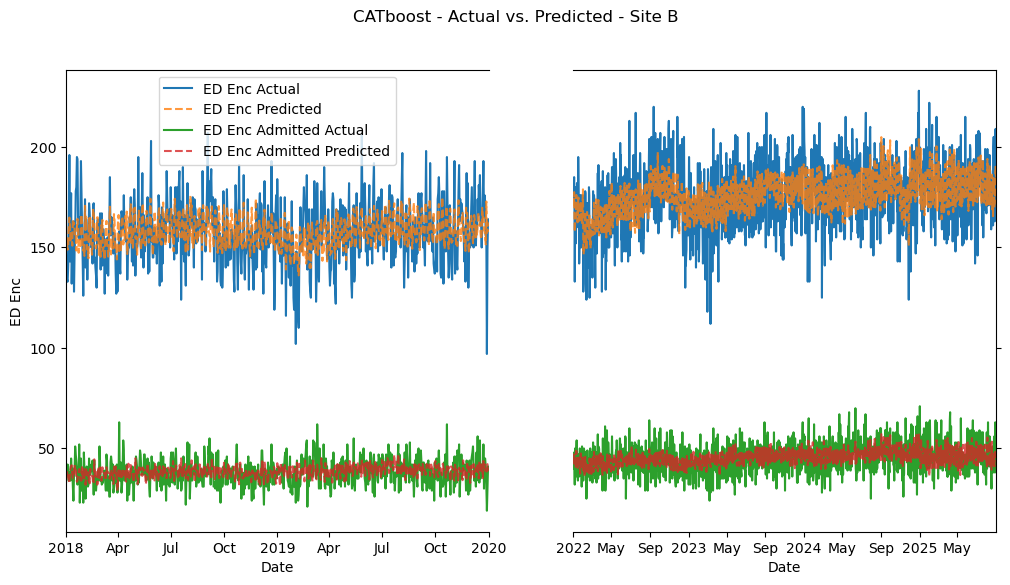

In [96]:
plot_df = siteB_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_catmodel.predict(siteB_X.to_pandas())
predict_df = siteB_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("CATboost - Actual vs. Predicted - Site B")
plt.show()

In [94]:
siteC_train_pool = Pool(siteC_X_train.to_pandas(), siteC_Y_train.to_pandas(), cat_features=siteC_X.columns)
siteC_test_pool = Pool(siteC_X_test.to_pandas(), siteC_Y_test.to_pandas(), cat_features=siteC_X.columns)

siteC_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteC_catmodel.fit(siteC_train_pool)

print(f"R² score of {siteC_catmodel.score(siteC_test_pool)}")

0:	learn: 10.4947379	total: 47.8ms	remaining: 47.7s
1:	learn: 9.8139953	total: 104ms	remaining: 51.7s
2:	learn: 9.2248420	total: 158ms	remaining: 52.6s
3:	learn: 8.7211428	total: 221ms	remaining: 55s
4:	learn: 8.2909703	total: 278ms	remaining: 55.3s
5:	learn: 7.9232963	total: 338ms	remaining: 56s
6:	learn: 7.6250773	total: 395ms	remaining: 56.1s
7:	learn: 7.3728040	total: 454ms	remaining: 56.3s
8:	learn: 7.1416281	total: 509ms	remaining: 56.1s
9:	learn: 6.9550874	total: 570ms	remaining: 56.5s
10:	learn: 6.7845702	total: 630ms	remaining: 56.6s
11:	learn: 6.6377921	total: 689ms	remaining: 56.8s
12:	learn: 6.5282548	total: 736ms	remaining: 55.9s
13:	learn: 6.4244403	total: 793ms	remaining: 55.8s
14:	learn: 6.3470597	total: 853ms	remaining: 56s
15:	learn: 6.2786226	total: 911ms	remaining: 56s
16:	learn: 6.2174559	total: 967ms	remaining: 55.9s
17:	learn: 6.1652399	total: 1.02s	remaining: 55.8s
18:	learn: 6.1172725	total: 1.09s	remaining: 56.4s
19:	learn: 6.0861578	total: 1.15s	remaining: 56

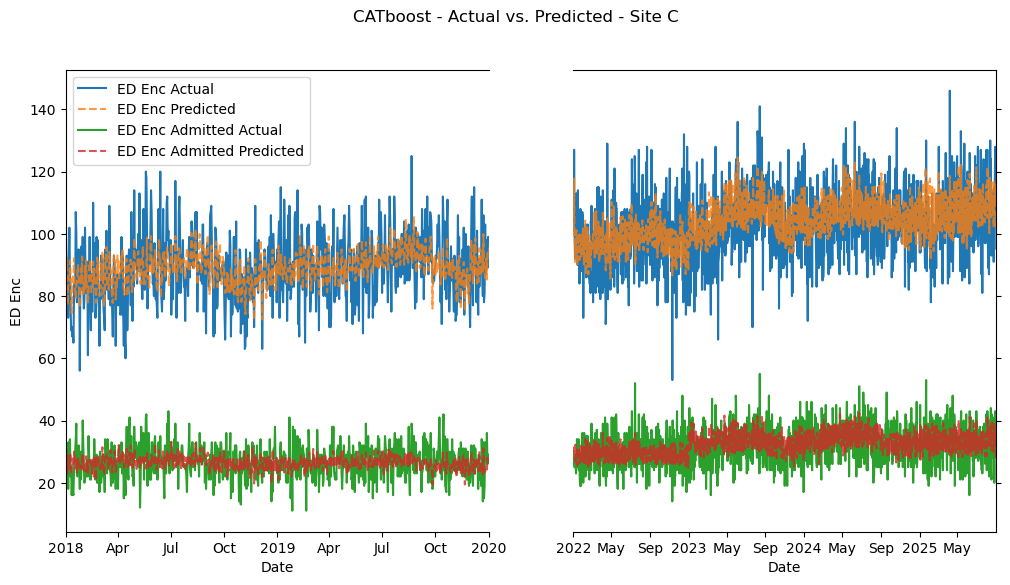

In [97]:
plot_df = siteC_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_catmodel.predict(siteC_X.to_pandas())
predict_df = siteC_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("CATboost - Actual vs. Predicted - Site C")
plt.show()

In [95]:
siteD_train_pool = Pool(siteD_X_train.to_pandas(), siteD_Y_train.to_pandas(), cat_features=siteD_X.columns)
siteD_test_pool = Pool(siteD_X_test.to_pandas(), siteD_Y_test.to_pandas(), cat_features=siteD_X.columns)

siteD_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteD_catmodel.fit(siteD_train_pool)

print(f"R² score of {siteD_catmodel.score(siteD_test_pool)}")

0:	learn: 8.1849157	total: 45.1ms	remaining: 45s
1:	learn: 7.6883789	total: 91.1ms	remaining: 45.5s
2:	learn: 7.2609076	total: 143ms	remaining: 47.5s
3:	learn: 6.8953230	total: 204ms	remaining: 50.7s
4:	learn: 6.5845220	total: 251ms	remaining: 49.9s
5:	learn: 6.3212328	total: 309ms	remaining: 51.2s
6:	learn: 6.1096913	total: 337ms	remaining: 47.8s
7:	learn: 5.9202003	total: 394ms	remaining: 48.8s
8:	learn: 5.7632593	total: 442ms	remaining: 48.7s
9:	learn: 5.6324732	total: 499ms	remaining: 49.4s
10:	learn: 5.5138129	total: 560ms	remaining: 50.3s
11:	learn: 5.4126313	total: 617ms	remaining: 50.8s
12:	learn: 5.3313168	total: 673ms	remaining: 51.1s
13:	learn: 5.2675155	total: 722ms	remaining: 50.8s
14:	learn: 5.2201128	total: 782ms	remaining: 51.4s
15:	learn: 5.1694987	total: 839ms	remaining: 51.6s
16:	learn: 5.1388819	total: 883ms	remaining: 51s
17:	learn: 5.1069291	total: 947ms	remaining: 51.7s
18:	learn: 5.0764606	total: 1.01s	remaining: 52s
19:	learn: 5.0516291	total: 1.06s	remaining: 

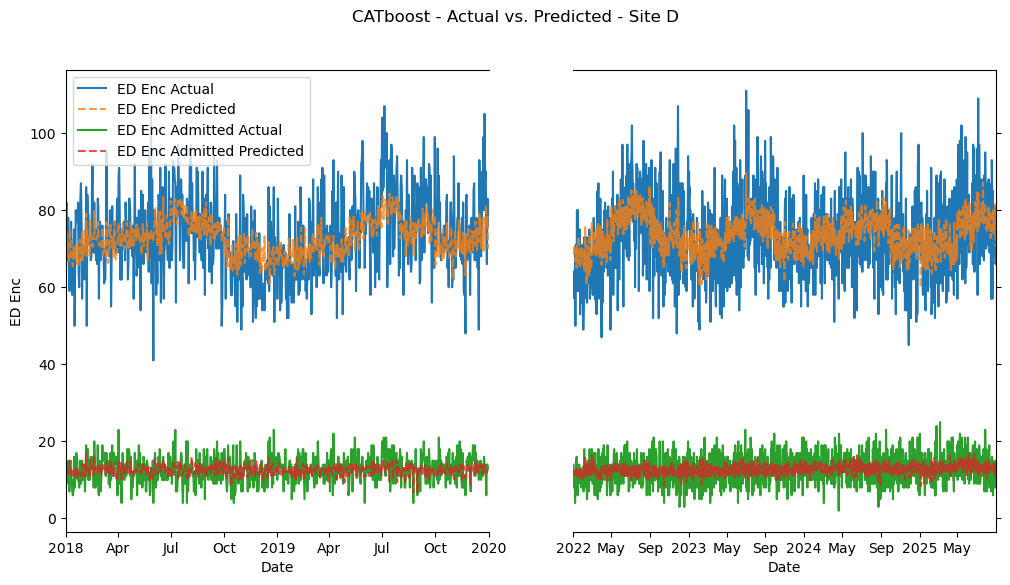

In [98]:
plot_df = siteD_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_catmodel.predict(siteD_X.to_pandas())
predict_df = siteD_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
fig.suptitle("CATboost - Actual vs. Predicted - Site D")
plt.show()